In [9]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf
import utils.eval_metrics as em

In [10]:
small = False # True for small dataset, False for big dataset


data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series

if small:
    all_groups = ["PAK", "SDN", "BDI", "HTI","EST", "CZE", "MLT", "SGP", "IRL", "CHE", "ISL", "NZL", "SWE"]
    data = data.loc[all_groups]
    title_prefix = "Small "
else:
    title_prefix = "Big "

N = data.index.shape[0]

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [1, 0.03, 5, 0.01, 0.5, 0.5] # Indifference thresholds
P = [10, 0.4, 20, 0.3, 5, 5]

Weight_vector = [1/L for _ in range(L)] # Equal weights times

alternatives = data.index # Alternatives are the countries

phi_c_all = pf.get_all_Phi_c(data, P, Q, L) # compute all mono criterion flows series
PHI = pf.PHI_all(phi_c_all, W, N, L, K) # Aggregate to the net flow series
PHI_df = pd.DataFrame(PHI, index=data.index, columns=np.arange(1990, 2023)) # Transform PHI into a dataframe with ISO3 as index and years as columns


eta = pf.get_eta_matrix(data, phi_c_all, W, L)
agg_eta = pf.aggregate_all_series(eta, Weight_vector)
dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

# Transform phi_c_all into a dataframe with ISO3 and variable names as columns (each cell is a np.array)
phi_c_all = np.array(phi_c_all)
variable_names = data.columns
phi_c_all_df = pd.DataFrame(index=alternatives, columns=variable_names)
for i in range(K):
    phi_c_all_df[variable_names[i]] = [phi_c_all[i][j] for j in range(N)]

Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


In [11]:
def get_n_GKM_results(n_samples, dist_matrix, data, k, prototype_method):
    """
    Run KMeans clustering on the data and return the labels and inertia.
    """
    all_clusterings = []
    for i in tqdm(range(n_samples)):
        # G_Kmedoid(data, dist_matrix, k=k, prototype_method="km++")
        clusters = cf.G_Kmedoid(data, dist_matrix, k=k, prototype_method=prototype_method)
        all_clusterings.append(clusters)
    return all_clusterings

def compare_GKM_initialization(n_samples, data, dist_matrix, k):
    """
    Compare the results of KMeans clustering with different initializations.
    """
    random_clusters = get_n_GKM_results(n_samples, dist_matrix, data, k, "random")
    kmpp_clusters = get_n_GKM_results(n_samples, dist_matrix, data, k, "km++")

    return random_clusters, kmpp_clusters

In [12]:
def evaluate_params(random_clusters, kmpp_clusters, data, method=em.evaluate_silhouette_on_data):
    """
    Evaluate the clustering results using different metrics.
    """
    # Evaluate the clustering results using different metrics
    random_score = np.array(method(random_clusters, data))
    kmpp_score = np.array(method(kmpp_clusters, data))

    return random_score, kmpp_score

def plot_scores(random_score_dunn, random_score_sil, kmpp_score_dunn, kmpp_score_sil):
    """
    Plot the indexes comparison for each clustering method.
    Using boxplots to show the distribution of the Dunn index for each method.
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot([random_score_dunn, random_score_sil, kmpp_score_dunn, kmpp_score_sil], 
                labels=["Random Dunn", "Random Silhouette", "KMeans++ Dunn", "KMeans++ Silhouette"])
    plt.title(f"Dunn and silhouette Indexes for GKM Clustering")
    plt.ylabel("Dunn and silhouette Indexes")
    plt.xlabel("Clustering Method")
    plt.show()

In [13]:
n_samples = 20
k = 5 # Number of clusters to evaluate
random_clusters, kmpp_clusters = compare_GKM_initialization(n_samples, data, dist_matrix, k)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


C:\Users\raphu\AppData\Local\Temp\ipykernel_23400\3933782891.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([random_score_dunn, random_score_sil, kmpp_score_dunn, kmpp_score_sil],


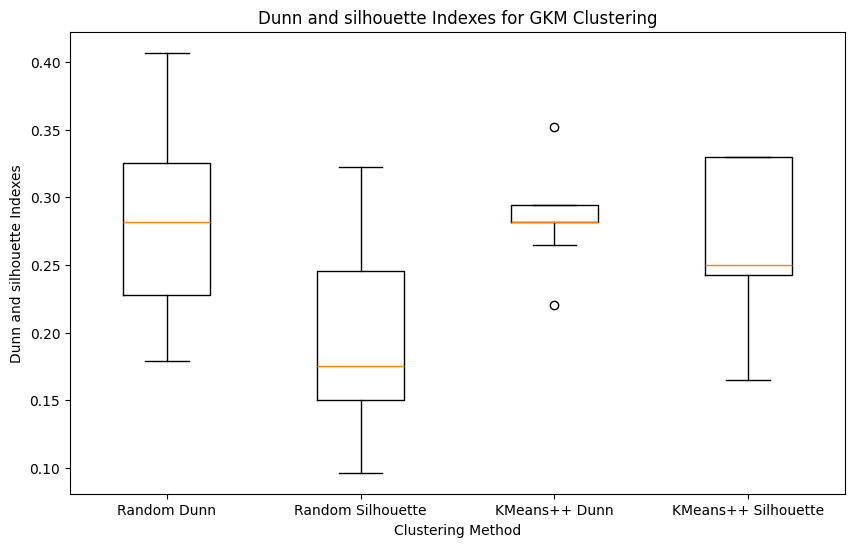

In [14]:
random_score_dunn, kmpp_score_dunn = evaluate_params(random_clusters, kmpp_clusters, data, method=em.evaluate_results_on_data)
random_score_sil, kmpp_score_sil = evaluate_params(random_clusters, kmpp_clusters, data, method=em.evaluate_silhouette_on_data)

plot_scores(random_score_dunn, random_score_sil, kmpp_score_dunn, kmpp_score_sil)


In [45]:
def euclidean_distance(point1, point2):
    return np.sum(np.linalg.norm(point1 - point2))

In [ ]:
def get_euclid_distance_matrix(data):
    """
    Compute the Euclidean distance matrix for the data.
    - data: DataFrame with the data (countries as index, variables as columns, each cell is a np.array)
    - Returns: DataFrame with the Euclidean distance matrix (countries as index and columns)
    """
    # Compute the Euclidean distance matrix
    dist_matrix = pd.DataFrame(index=data.index, columns=data.index)
    for i in range(len(data.index)):
        for j in range(len(data.index)):
            if i != j:
                dist_matrix.iloc[i, j] = euclidean_distance(data.iloc[i], data.iloc[j])
            else:
                dist_matrix.iloc[i, j] = 0
    # Fill the diagonal with 0s
    dist_matrix.values[[np.arange(len(dist_matrix))]*2] = 0
    return dist_matrix

euclid_dist_matrix = get_euclid_distance_matrix(data)

100%|██████████| 20/20 [00:01<00:00, 18.70it/s]
C:\Users\raphu\AppData\Local\Temp\ipykernel_23400\3933782891.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([random_score_dunn, random_score_sil, kmpp_score_dunn, kmpp_score_sil],


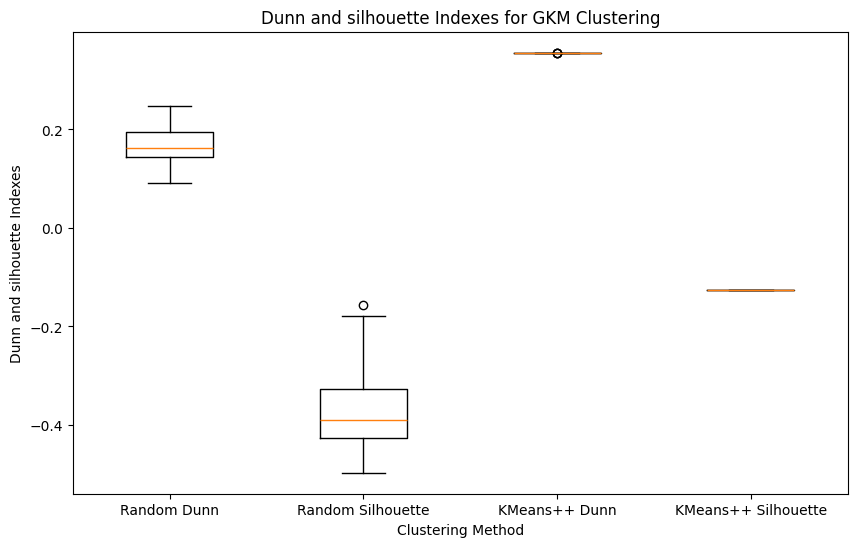

In [19]:
random_clusters_euclid = get_n_GKM_results(n_samples, euclid_dist_matrix, data, k, "random")
kmpp_clusters_euclid = get_n_GKM_results(n_samples, euclid_dist_matrix, data, k, "km++")

random_score_dunn_euclid, kmpp_score_dunn_euclid = evaluate_params(random_clusters_euclid, kmpp_clusters_euclid, data, method=em.evaluate_results_on_data)
random_score_sil_euclid, kmpp_score_sil_euclid = evaluate_params(random_clusters_euclid, kmpp_clusters_euclid, data, method=em.evaluate_silhouette_on_data)

plot_scores(random_score_dunn_euclid, random_score_sil_euclid, kmpp_score_dunn_euclid, kmpp_score_sil_euclid)

C:\Users\raphu\AppData\Local\Temp\ipykernel_23400\1853586312.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([euclid_kmpp_dunn, dist_matrix_kmpp_dunn, euclid_kmpp_sil, dist_matrix_kmpp_sil],


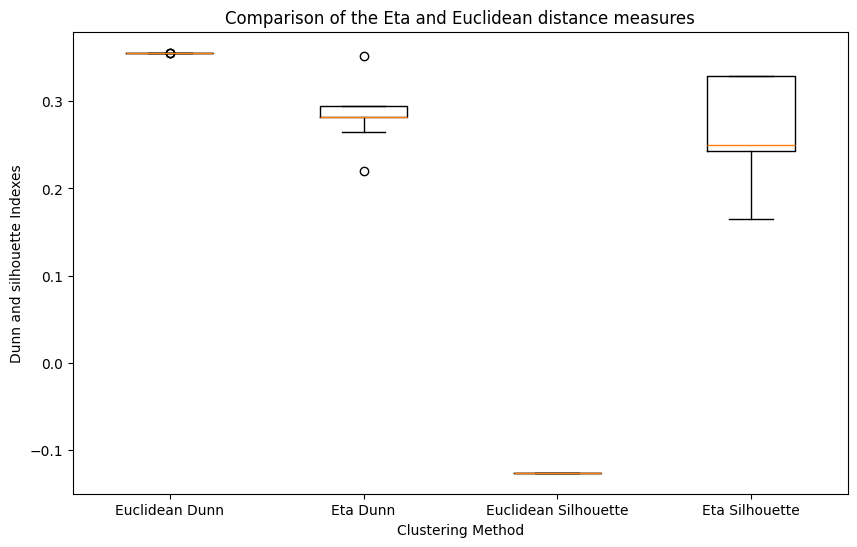

In [53]:
def compare_dist_matrix(euclid_kmpp_dunn, euclid_kmpp_sil, dist_matrix_kmpp_dunn, dist_matrix_kmpp_sil):
    """
    Compare the results of KMeans clustering with different distance matrices.
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot([euclid_kmpp_dunn, dist_matrix_kmpp_dunn, euclid_kmpp_sil, dist_matrix_kmpp_sil], 
                labels=["Euclidean Dunn", "Eta Dunn", "Euclidean Silhouette", "Eta Silhouette"])
    plt.title(f"Comparison of the Eta and Euclidean distance measures")
    plt.ylabel("Dunn and silhouette Indexes")
    plt.xlabel("Clustering Method")
    plt.show()

compare_dist_matrix(kmpp_score_dunn_euclid, kmpp_score_sil_euclid, kmpp_score_dunn, kmpp_score_sil)